# R4 Agent

In [ ]:
# r4_agent_gemini.py
# R4 = Route → Retrieve → Reflect → Repair with pass@3 using Gemini 2.5 Flash(-Lite)

import os, io, gc, time, json, base64, hashlib, random, re
from dataclasses import dataclass, field
from typing import List, Dict, Any, Optional, Tuple
import requests
from PIL import Image

# ----------------- USER CONFIG -----------------
MERGED_CSV    = "/kaggle/input/dsetindiana/indiana_merged.csv"   # <-- change if needed
IMAGES_FOLDER = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized"
OUTPUT_CSV    = "gemini_zero_shot_results_batch.csv"  # renamed

MAX_ROWS          = 100     # max unique uids to process
MAX_NEW_TOKENS    = 400     # short paragraph target
FLUSH_EVERY       = 50
CLEAN_CACHE_EVERY = 25
DOWNSCALE_IMAGES  = True
MAX_IMAGE_SIDE    = 1024

# =========================
# 0) Gemini HTTP Client + Config
# =========================

# (Option A) Put keys here (list may be empty; env fallback used if so)
GEMINI_API_KEYS: List[str] = [
    # os.environ.get("GEMINI_API_KEY"),  # example (single key)
    # "YOUR_KEY_1", "YOUR_KEY_2", ...
]

# (Option B) Endpoint (Flash-Lite; update if needed)
GEMINI_ENDPOINT: str = "https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent"

class GeminiClient:
    def __init__(self, api_keys: List[str] = None,
                 endpoint: str = GEMINI_ENDPOINT,
                 timeout: int = 90):
        if api_keys is None or len(api_keys) == 0:
            env_keys = [k.strip() for k in os.environ.get("GEMINI_API_KEYS","").split(",") if k.strip()]
            api_keys = env_keys
        assert api_keys, "No Gemini API keys. Set GEMINI_API_KEYS env or pass a list."
        self.api_keys = api_keys
        self.endpoint = endpoint
        self.timeout = timeout
        self.idx = 0

    def _key(self):
        return self.api_keys[self.idx]

    def _rotate(self):
        self.idx = (self.idx + 1) % len(self.api_keys)

    def generate(self, system_text: str, user_parts: List[Dict[str, Any]],
                 max_tokens: int = 800, temperature: float = 0.0) -> Tuple[Optional[str], Optional[str]]:
        payload = {
            "systemInstruction": {"parts": [{"text": system_text.strip()}]},
            "contents": [{"role":"user", "parts": user_parts}],
            "generationConfig": {
                "maxOutputTokens": int(max_tokens),
                "temperature": float(temperature),
                "topK": 40,
                "topP": 0.95
            }
        }
        attempts, backoff = 0, 1.0
        max_attempts = len(self.api_keys)*2

        while attempts < max_attempts:
            attempts += 1
            try:
                r = requests.post(
                    f"{self.endpoint}?key={self._key()}",
                    headers={"Content-Type": "application/json"},
                    data=json.dumps(payload),
                    timeout=self.timeout
                )
            except requests.RequestException:
                time.sleep(backoff); backoff = min(backoff*2, 16); continue

            if r.status_code == 200:
                try:
                    data = r.json()
                    cands = data.get("candidates", [])
                    if not cands:
                        br = data.get("promptFeedback",{}).get("blockReason")
                        return None, f"Blocked/empty: {br or 'no candidates'}"
                    parts = cands[0]["content"]["parts"]
                    txt = "\n".join([p.get("text","") for p in parts if "text" in p]).strip()
                    return (txt if txt else None), (None if txt else "Empty text")
                except Exception as e:
                    return None, f"Parse error: {e}"
            elif r.status_code in (429, 500, 502, 503, 504):
                # rate/quotas/server
                try:
                    body = r.json()
                except Exception:
                    body = {"error":{"message": r.text}}
                msg = (body.get("error",{}) or {}).get("message", r.text)
                if r.status_code == 429 or "quota" in msg.lower() or "rate" in msg.lower():
                    self._rotate()
                time.sleep(backoff); backoff = min(backoff*2, 16); continue
            elif r.status_code in (401,403):
                self._rotate()
                time.sleep(backoff); backoff = min(backoff*2, 16); continue
            else:
                try:
                    body = r.json()
                except Exception:
                    body = {"error":{"message": r.text}}
                return None, f"HTTP {r.status_code}: {(body.get('error',{}) or {}).get('message', r.text)}"

        return None, "All keys exhausted / repeated failures"


# =========================
# 1) Utilities
# =========================
def image_to_b64_jpeg(img: Image.Image, max_side=1024, quality=90) -> Tuple[str, str]:
    # downscale
    if DOWNSCALE_IMAGES:
        w, h = img.size
        s = max(w, h)
        if s > max_side:
            scale = max_side / s
            img = img.resize((int(w*scale), int(h*scale)), Image.LANCZOS)
    if img.mode != "RGB":
        img = img.convert("RGB")
    buf = io.BytesIO()
    img.save(buf, format="JPEG", quality=quality, optimize=True)
    return base64.b64encode(buf.getvalue()).decode("utf-8"), "image/jpeg"

def sha_short(s: str, n=10) -> str:
    return hashlib.sha1(s.encode("utf-8")).hexdigest()[:n]

def normalize_space(s: str) -> str:
    return re.sub(r"\s+", " ", s or "").strip()

# =========================
# 2) Curator Memory (JSONL)
# =========================
class MemoryStore:
    """
    Lightweight exemplar memory:
    - append({"task": "cxr_report" or "medvqa",
              "lang": "en"/"bn",
              "cue": short textual cue,
              "prompt": few-shot exemplar text,
              "final": final_answer,
              "tags": ["negation","effusion","laterality", ...]})
    - retrieve top-k by simple keyword overlap.
    """
    def __init__(self, path: str = "r4_memory.jsonl"):
        self.path = path
        self.items = []
        if os.path.exists(path):
            with open(path, "r", encoding="utf-8") as f:
                for line in f:
                    try:
                        self.items.append(json.loads(line))
                    except:
                        pass

    def add(self, item: Dict[str, Any]):
        self.items.append(item)
        with open(self.path, "a", encoding="utf-8") as f:
            f.write(json.dumps(item, ensure_ascii=False)+"\n")

    def retrieve(self, task: str, lang: str, cue: str, k: int = 3) -> List[Dict[str, Any]]:
        cue_words = set(normalize_space(cue).lower().split())
        scored = []
        for it in self.items:
            if it.get("task") != task: continue
            if it.get("lang") != lang: continue
            cand_words = set(normalize_space(it.get("cue","")).lower().split()) | set(it.get("tags",[]))
            score = len(cue_words & cand_words)
            if score > 0:
                scored.append((score, it))
        scored.sort(key=lambda x: x[0], reverse=True)
        return [it for _, it in scored[:k]]


# =========================
# 3) Prompts
# =========================

SYSTEM_ROUTE = """You are a senior coordinator deciding how to process medical vision-language tasks.
Choose (a) task type, (b) language, (c) prompt mode (zero-shot, few-shot, or chain-of-thought),
and (d) any special flags (e.g., strict negation checking). Respond in strict JSON with:
{"task": "...", "lang":"...", "mode":"...", "flags":["..."]}"""

SYSTEM_RETRIEVE = """You are an expert radiologist/clinician generating clinically faithful outputs from an image.
Follow the requested style and language. Avoid hallucinations."""

SYSTEM_REFLECT = """You are a safety and clinical QA checker for radiology/VQA. Find problems:
- Negation errors (saying present when absent, or vice versa)
- Laterality errors (left/right swapped)
- Unsupported claims (not inferable from typical CXR/VQA evidence)
- Contradictions between sections
- Missing key positives/negatives (e.g., effusion, consolidation, pneumothorax, cardiomegaly)
Return a JSON list of issues: [{"type":"negation/laterality/unsupported/contradiction/missing","where":"...", "msg":"...","fix":"..."}]"""

SYSTEM_REPAIR = """You are an expert reviser. Fix the draft using the issue list. Keep it concise and clinically precise.
Do not invent findings. Prefer uncertainty over fabrication. Output the final answer only."""

# CXR report styles
PROMPT_CXR_ZERO = """Analyze the chest X-ray and produce a short, single-paragraph radiology report. Be precise. If normal, say so clearly."""
PROMPT_CXR_COT = """You are an expert radiologist. Perform:
1) Region-wise assessment (Heart, Aorta, Cardiac silhouette, Diaphragm, Costophrenic angles, Hila, Lungs, Mediastinum, Pleura, Pulmonary arteries, Trachea, Bones, Soft tissues) with:
Region: [name]
Status: Normal / Abnormal
Findings: [...]
2) Reevaluation of (Heart, Aorta, Cardiac silhouette, Diaphragm, Costophrenic angles, Hila, Lungs, Mediastinum, Pleura, Pulmonary arteries, Trachea) listing any subtle uncertainties or corrections.
Finish with one-sentence residual uncertainty.
"""

# VQA styles
PROMPT_VQA_ZERO = """Answer the medical visual question briefly and clinically. If uncertain, say "uncertain"."""
PROMPT_VQA_FEWSHOT_HEADER = """Below are exemplar QA pairs to guide style and clinical caution:"""

# Simple Bangla wrappers (adjust phrasing as needed)
def wrap_bn(s: str) -> str:
    return f"নির্দেশনা (বাংলা): {s}"

# =========================
# 4) R4 Agents
# =========================
@dataclass
class RouterOutput:
    task: str       # "cxr_report" or "medvqa"
    lang: str       # "en" or "bn"
    mode: str       # "zero" | "few" | "cot"
    flags: List[str] = field(default_factory=list)

class Router:
    def __init__(self, client: GeminiClient):
        self.client = client

    def route(self, hint: Dict[str, Any]) -> RouterOutput:
        """
        hint can include: {"question": "...", "prefer_lang":"bn", "task_hint":"medvqa"|"cxr_report"}
        """
        # Heuristic fast-path (avoid extra LLM call)
        prefer_lang = hint.get("prefer_lang","en").lower()
        task = hint.get("task_hint")
        mode = hint.get("mode_hint")
        flags = ["negation_check","laterality_check"]

        if not task:
            task = "medvqa" if hint.get("question") else "cxr_report"
        if not mode:
            # simple policy: VQA→zero (or few if memory), CXR→cot
            mode = "zero" if task=="medvqa" else "cot"

        # Let Gemini decide if desired (kept enabled per your last version)
        user_parts = [{"text": json.dumps(hint)}]
        txt, err = self.client.generate(SYSTEM_ROUTE, user_parts, max_tokens=120, temperature=0.0)
        if not err:
            try:
                d = json.loads(txt)
                return RouterOutput(d["task"], d["lang"], d["mode"], d.get("flags",[]))
            except:
                pass

        return RouterOutput(task=task, lang=("bn" if prefer_lang.startswith("b") else "en"), mode=mode, flags=flags)

class Retriever:
    def __init__(self, client: GeminiClient, memory: MemoryStore, k: int = 3):
        self.client = client
        self.memory = memory
        self.k = k

    def _compose_user_parts(self, task: str, lang: str, mode: str,
                            img_b64: str, img_mime: str,
                            question: Optional[str], fewshots: List[Dict[str,Any]]) -> List[Dict[str,Any]]:
        parts = []
        # header prompt by task/mode/lang
        if task == "cxr_report":
            if mode == "cot":
                p = PROMPT_CXR_COT
            elif mode == "few":
                p = PROMPT_CXR_ZERO  # style stays concise; exemplars carry style
            else:
                p = PROMPT_CXR_ZERO
        else:
            # medvqa
            p = PROMPT_VQA_ZERO
            if question:
                p += f"\nQuestion: {question}\nAnswer:"

        if lang == "bn":
            p = wrap_bn(p)

        # few-shot exemplars
        if fewshots:
            ex_texts = []
            if task == "cxr_report":
                for e in fewshots:
                    ex_texts.append(f"Example Report:\n{e.get('final')}")
            else:
                ex_texts.append(PROMPT_VQA_FEWSHOT_HEADER)
                for e in fewshots:
                    ex_texts.append(f"Q: {e.get('cue')}\nA: {e.get('final')}")
            parts.append({"text":"\n\n".join(ex_texts)})

        parts.append({"text": p})
        parts.append({"inline_data": {"mime_type": img_mime, "data": img_b64}})
        return parts

    def draft(self, route: RouterOutput, img: Image.Image,
              question: Optional[str] = None,
              max_tokens: int = MAX_NEW_TOKENS,
              temperature: float = 0.0) -> Tuple[str, Dict[str,Any]]:
        # retrieve exemplars
        cue = question or "cxr"
        few = self.memory.retrieve(task=route.task, lang=route.lang, cue=cue, k=(3 if route.mode in ("few","cot") else 0))

        # build message
        img_b64, mime = image_to_b64_jpeg(img, max_side=MAX_IMAGE_SIDE)
        user_parts = self._compose_user_parts(route.task, route.lang, route.mode, img_b64, mime, question, few)

        txt, err = self.client.generate(system_text=SYSTEM_RETRIEVE, user_parts=user_parts,
                                        max_tokens=max_tokens, temperature=temperature)
        out = txt if txt else (err or "ERROR")
        meta = {"fewshots_used": len(few), "mode": route.mode, "lang": route.lang, "task": route.task, "temperature": temperature}
        return out, meta

class Reflector:
    def __init__(self, client: GeminiClient):
        self.client = client

    def critique(self, img: Image.Image, draft: str, question: Optional[str] = None,
                 max_tokens: int = MAX_NEW_TOKENS) -> List[Dict[str,Any]]:
        img_b64, mime = image_to_b64_jpeg(img, max_side=MAX_IMAGE_SIDE)
        critique_prompt = f"""Critique this draft for clinical issues and return JSON list only.

DRAFT:
{draft}

{'QUESTION: ' + question if question else ''}"""
        parts = [{"text": critique_prompt}, {"inline_data":{"mime_type":mime, "data":img_b64}}]
        txt, err = self.client.generate(SYSTEM_REFLECT, parts, max_tokens=max_tokens, temperature=0.0)
        if err:
            return [{"type":"system","where":"n/a","msg":f"reflect_error:{err}","fix":"re-run or simplify"}]
        try:
            data = json.loads(txt)
            if isinstance(data, list): return data
            return [{"type":"parse","where":"n/a","msg":"reflect_nonlist","fix":"ensure JSON list"}]
        except Exception:
            # try to extract JSON block
            m = re.search(r"\[[\s\S]*\]", txt)
            if m:
                try:
                    return json.loads(m.group(0))
                except:
                    pass
            return [{"type":"parse","where":"n/a","msg":"reflect_json_fail","fix":"re-run"}]

class Repairer:
    def __init__(self, client: GeminiClient):
        self.client = client

    def revise(self, img: Image.Image, draft: str, issues: List[Dict[str,Any]],
               lang: str, task: str, max_tokens: int = MAX_NEW_TOKENS) -> str:
        img_b64, mime = image_to_b64_jpeg(img, max_side=MAX_IMAGE_SIDE)
        issues_json = json.dumps(issues, ensure_ascii=False, indent=2)
        constraints = "Language: Bangla." if lang == "bn" else "Language: English."
        style = "Produce a final radiology report." if task=="cxr_report" else "Produce a final clinical answer."
        prompt = f"""{constraints}
{style}
Fix the DRAFT using ISSUES. Do not add unsupported findings.

DRAFT:
{draft}

ISSUES (JSON):
{issues_json}
"""
        parts = [{"text": prompt}, {"inline_data":{"mime_type":mime,"data":img_b64}}]
        txt, err = self.client.generate(SYSTEM_REPAIR, parts, max_tokens=max_tokens, temperature=0.0)
        return txt or f"ERROR: {err}"

class Curator:
    def __init__(self, memory: MemoryStore):
        self.memory = memory

    def make_cue(self, task: str, question: Optional[str], final: str) -> str:
        if task == "medvqa":
            return normalize_space(question or "")
        # cxr: compress to a cue of key entities
        m = re.findall(r"(pneumothorax|effusion|consolidation|atelectasis|cardiomegaly|emphysema|scarring|pleural\s+thickening|normal)", final.lower())
        keys = list(dict.fromkeys(m))  # unique order
        return " ".join(keys) or "cxr"

    def tags(self, final: str) -> List[str]:
        toks = ["negation" if "no " in final.lower() else "",
                "laterality" if re.search(r"\b(left|right)\b", final.lower()) else ""]
        return [t for t in toks if t]

    def add_example(self, task: str, lang: str, question: Optional[str], final: str):
        item = {
            "task": task, "lang": lang,
            "cue": self.make_cue(task, question, final),
            "prompt": "",  # optional: store the prompt if desired
            "final": final,
            "tags": self.tags(final)
        }
        self.memory.add(item)


# =========================
# 5) Orchestrator (R4) with pass@3
# =========================
class R4Agent:
    def __init__(self, client: GeminiClient, memory_path: str = "r4_memory.jsonl"):
        self.client = client
        self.memory = MemoryStore(memory_path)
        self.router = Router(client)
        self.retriever = Retriever(client, self.memory)
        self.reflector = Reflector(client)
        self.repairer = Repairer(client)
        self.curator = Curator(self.memory)

    @staticmethod
    def _score_issues(issues: List[Dict[str,Any]]) -> int:
        """
        Higher is better.
        We penalize by counting issues with weights.
        """
        weights = {
            "missing": 3,
            "contradiction": 3,
            "unsupported": 2,
            "laterality": 2,
            "negation": 2,
        }
        penalty = 0
        for it in issues:
            t = (it.get("type") or "").lower()
            if t in ("system", "parse"):  # do not penalize system/parse noise heavily
                penalty += 0
            else:
                penalty += weights.get(t, 1)
        return -penalty  # more issues → lower score

    def run(self, img: Image.Image, task_hint: Optional[str] = None,
            prefer_lang: str = "en", question: Optional[str] = None,
            mode_hint: Optional[str] = None, max_passes: int = 2,
            pass_k: int = 3, draft_temperature: float = 0.3) -> Dict[str,Any]:

        # Route
        route = self.router.route({
            "task_hint": task_hint,
            "prefer_lang": prefer_lang,
            "mode_hint": mode_hint,
            "question": question
        })

        # ==== PASS@K DRAFTS ====
        draft_candidates = []
        for k in range(pass_k):
            temp = draft_temperature if pass_k > 1 else 0.0
            draft_k, meta_k = self.retriever.draft(
                route, img, question=question,
                max_tokens=MAX_NEW_TOKENS,
                temperature=temp
            )
            issues_k = self.reflector.critique(img, draft_k, question=question)
            score_k = self._score_issues(issues_k)
            draft_candidates.append({
                "draft": draft_k,
                "issues": issues_k,
                "score": score_k,
                "meta": meta_k
            })

        # Pick best draft by score (highest is best)
        draft_candidates.sort(key=lambda x: x["score"], reverse=True)
        chosen = draft_candidates[0]
        draft = chosen["draft"]
        all_issues = list(chosen["issues"])  # start with chosen draft issues

        # ==== Reflect & Repair on the chosen draft ====
        final = draft
        for _ in range(max_passes):
            issues = self.reflector.critique(img, final, question=question)
            all_issues.extend(issues)
            # if nothing material found, break
            if not [x for x in issues if x.get("type") not in ("system","parse")]:
                break
            final = self.repairer.revise(img, final, issues, route.lang, route.task,
                                         max_tokens=MAX_NEW_TOKENS)

        # Curate successful example
        if isinstance(final, str) and not final.startswith("ERROR"):
            self.curator.add_example(task=route.task, lang=route.lang, question=question, final=final)

        return {
            "route": route.__dict__,
            "pass_k": pass_k,
            "draft_temperature": draft_temperature,
            "drafts": draft_candidates,     # includes score & issues
            "chosen_index": 0,
            "final": final
        }


# =========================
# 6) Minimal CLI / Notebook-friendly usage
# =========================
if __name__ == "__main__":
    import argparse
    import pandas as pd

    parser = argparse.ArgumentParser(description="R4 Agent (Gemini) for CXR or MedVQA", add_help=True)
    parser.add_argument("--img", "-i", type=str, default=None, help="Path to image file")
    parser.add_argument("--task", "-t", type=str, default="cxr_report", choices=["cxr_report", "medvqa"],
                        help="Task type: cxr_report or medvqa")
    parser.add_argument("--lang", "-l", type=str, default="en", choices=["en", "bn"], help="Output language")
    parser.add_argument("--question", "-q", type=str, default=None, help="Question (for medvqa)")
    parser.add_argument("--passk", type=int, default=3, help="pass@k drafts")
    parser.add_argument("--temp", type=float, default=0.3, help="draft sampling temperature")

    # Ignore unknown Jupyter/Kaggle args like '-f'
    args, _unknown = parser.parse_known_args()

    img_path = args.img
    task_hint = args.task
    lang = args.lang
    question = args.question
    pass_k = args.passk
    draft_temperature = args.temp

    # If no valid --img given, try to auto-pick first image from MERGED_CSV
    if not img_path or img_path.startswith("-") or not os.path.exists(img_path):
        try:
            df = pd.read_csv(MERGED_CSV, usecols=["filename"])
            if len(df) == 0:
                raise FileNotFoundError("MERGED_CSV has no rows.")
            candidate = os.path.join(IMAGES_FOLDER, df.iloc[0]["filename"])
            if not os.path.exists(candidate):
                raise FileNotFoundError(f"Auto-picked image not found: {candidate}")
            img_path = candidate
            print(f"[Info] No/invalid --img supplied. Using first CSV image: {img_path}")
        except Exception as e:
            print("Usage: python r4_agent_gemini.py --img /path/to/cxr.png --task cxr_report --lang en [--question '...']")
            print(f"[Error] Could not resolve an image automatically: {e}")
            raise

    with Image.open(img_path) as im:
        client = GeminiClient(api_keys=GEMINI_API_KEYS)  # uses env fallback if list empty
        agent = R4Agent(client, memory_path="r4_memory.jsonl")
        out = agent.run(
            im,
            task_hint=task_hint,
            prefer_lang=lang,
            question=question,
            mode_hint=None,
            max_passes=2,
            pass_k=pass_k,               # pass@k (default 3)
            draft_temperature=draft_temperature
        )

    print(json.dumps(out, ensure_ascii=False, indent=2))

[Info] No/invalid --img supplied. Using first CSV image: /kaggle/input/chest-xrays-indiana-university/images/images_normalized/1_IM-0001-4001.dcm.png
{
  "route": {
    "task": "cxr_report",
    "lang": "en",
    "mode": "cot",
    "flags": [
      "negation_check",
      "laterality_check"
    ]
  },
  "pass_k": 3,
  "draft_temperature": 0.3,
  "drafts": [
    {
      "draft": "Here's the region-wise assessment of the chest X-ray:\n\n**Region-wise assessment:**\n\n*   **Heart:**\n    *   Status: Normal\n    *   Findings: The cardiac silhouette is within normal limits for size and contour.\n*   **Aorta:**\n    *   Status: Normal\n    *   Findings: The visualized portion of the aorta appears normal.\n*   **Cardiac silhouette:**\n    *   Status: Normal\n    *   Findings: The cardiac silhouette is within normal limits for size and contour.\n*   **Diaphragm:**\n    *   Status: Normal\n    *   Findings: Both hemidiaphragms are well-defined and in their normal position.\n*   **Costophrenic a

In [ ]:
# r4_agent_gemini.py
# R4 = Route → Retrieve → Reflect → Repair with pass@3 using Gemini 2.5 Flash(-Lite)

import os, io, gc, time, json, base64, hashlib, random, re
from dataclasses import dataclass, field
from typing import List, Dict, Any, Optional, Tuple
import requests
from PIL import Image

# ----------------- USER CONFIG -----------------
MERGED_CSV    = "/kaggle/input/dsetindiana/indiana_merged.csv"   # <-- change if needed
IMAGES_FOLDER = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized"
OUTPUT_CSV    = "gemini_zero_shot_results_batch.csv"  # renamed

MAX_ROWS          = 100     # max unique uids to process
MAX_NEW_TOKENS    = 400     # short paragraph target
FLUSH_EVERY       = 50
CLEAN_CACHE_EVERY = 25
DOWNSCALE_IMAGES  = True
MAX_IMAGE_SIDE    = 1024

# =========================
# 0) Gemini HTTP Client + Config
# =========================

# (Option A) Put keys here (list may be empty; env fallback used if so)
GEMINI_API_KEYS: List[str] = [
    # os.environ.get("GEMINI_API_KEY"),  # example (single key)
    # "YOUR_KEY_1", "YOUR_KEY_2", ...
]

# (Option B) Endpoint (Flash-Lite; update if needed)
GEMINI_ENDPOINT: str = "https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent"

class GeminiClient:
    def __init__(self, api_keys: List[str] = None,
                 endpoint: str = GEMINI_ENDPOINT,
                 timeout: int = 90):
        if api_keys is None or len(api_keys) == 0:
            env_keys = [k.strip() for k in os.environ.get("GEMINI_API_KEYS","").split(",") if k.strip()]
            api_keys = env_keys
        assert api_keys, "No Gemini API keys. Set GEMINI_API_KEYS env or pass a list."
        self.api_keys = api_keys
        self.endpoint = endpoint
        self.timeout = timeout
        self.idx = 0

    def _key(self):
        return self.api_keys[self.idx]

    def _rotate(self):
        self.idx = (self.idx + 1) % len(self.api_keys)

    def generate(self, system_text: str, user_parts: List[Dict[str, Any]],
                 max_tokens: int = 800, temperature: float = 0.0) -> Tuple[Optional[str], Optional[str]]:
        payload = {
            "systemInstruction": {"parts": [{"text": system_text.strip()}]},
            "contents": [{"role":"user", "parts": user_parts}],
            "generationConfig": {
                "maxOutputTokens": int(max_tokens),
                "temperature": float(temperature),
                "topK": 40,
                "topP": 0.95
            }
        }
        attempts, backoff = 0, 1.0
        max_attempts = len(self.api_keys)*2

        while attempts < max_attempts:
            attempts += 1
            try:
                r = requests.post(
                    f"{self.endpoint}?key={self._key()}",
                    headers={"Content-Type": "application/json"},
                    data=json.dumps(payload),
                    timeout=self.timeout
                )
            except requests.RequestException:
                time.sleep(backoff); backoff = min(backoff*2, 16); continue

            if r.status_code == 200:
                try:
                    data = r.json()
                    cands = data.get("candidates", [])
                    if not cands:
                        br = data.get("promptFeedback",{}).get("blockReason")
                        return None, f"Blocked/empty: {br or 'no candidates'}"
                    parts = cands[0]["content"]["parts"]
                    txt = "\n".join([p.get("text","") for p in parts if "text" in p]).strip()
                    return (txt if txt else None), (None if txt else "Empty text")
                except Exception as e:
                    return None, f"Parse error: {e}"
            elif r.status_code in (429, 500, 502, 503, 504):
                # rate/quotas/server
                try:
                    body = r.json()
                except Exception:
                    body = {"error":{"message": r.text}}
                msg = (body.get("error",{}) or {}).get("message", r.text)
                if r.status_code == 429 or "quota" in msg.lower() or "rate" in msg.lower():
                    self._rotate()
                time.sleep(backoff); backoff = min(backoff*2, 16); continue
            elif r.status_code in (401,403):
                self._rotate()
                time.sleep(backoff); backoff = min(backoff*2, 16); continue
            else:
                try:
                    body = r.json()
                except Exception:
                    body = {"error":{"message": r.text}}
                return None, f"HTTP {r.status_code}: {(body.get('error',{}) or {}).get('message', r.text)}"

        return None, "All keys exhausted / repeated failures"


# =========================
# 1) Utilities
# =========================
def image_to_b64_jpeg(img: Image.Image, max_side=1024, quality=90) -> Tuple[str, str]:
    # downscale
    if DOWNSCALE_IMAGES:
        w, h = img.size
        s = max(w, h)
        if s > max_side:
            scale = max_side / s
            img = img.resize((int(w*scale), int(h*scale)), Image.LANCZOS)
    if img.mode != "RGB":
        img = img.convert("RGB")
    buf = io.BytesIO()
    img.save(buf, format="JPEG", quality=quality, optimize=True)
    return base64.b64encode(buf.getvalue()).decode("utf-8"), "image/jpeg"

def sha_short(s: str, n=10) -> str:
    return hashlib.sha1(s.encode("utf-8")).hexdigest()[:n]

def normalize_space(s: str) -> str:
    return re.sub(r"\s+", " ", s or "").strip()

# =========================
# 2) Curator Memory (JSONL)
# =========================
class MemoryStore:
    """
    Lightweight exemplar memory:
    - append({"task": "cxr_report" or "medvqa",
              "lang": "en"/"bn",
              "cue": short textual cue,
              "prompt": few-shot exemplar text,
              "final": final_answer,
              "tags": ["negation","effusion","laterality", ...]})
    - retrieve top-k by simple keyword overlap.
    """
    def __init__(self, path: str = "r4_memory.jsonl"):
        self.path = path
        self.items = []
        if os.path.exists(path):
            with open(path, "r", encoding="utf-8") as f:
                for line in f:
                    try:
                        self.items.append(json.loads(line))
                    except:
                        pass

    def add(self, item: Dict[str, Any]):
        self.items.append(item)
        with open(self.path, "a", encoding="utf-8") as f:
            f.write(json.dumps(item, ensure_ascii=False)+"\n")

    def retrieve(self, task: str, lang: str, cue: str, k: int = 3) -> List[Dict[str, Any]]:
        cue_words = set(normalize_space(cue).lower().split())
        scored = []
        for it in self.items:
            if it.get("task") != task: continue
            if it.get("lang") != lang: continue
            cand_words = set(normalize_space(it.get("cue","")).lower().split()) | set(it.get("tags",[]))
            score = len(cue_words & cand_words)
            if score > 0:
                scored.append((score, it))
        scored.sort(key=lambda x: x[0], reverse=True)
        return [it for _, it in scored[:k]]


# =========================
# 3) Prompts
# =========================

SYSTEM_ROUTE = """You are a senior coordinator deciding how to process medical vision-language tasks.
Choose (a) task type, (b) language, (c) prompt mode (zero-shot, few-shot, or chain-of-thought),
and (d) any special flags (e.g., strict negation checking). Respond in strict JSON with:
{"task": "...", "lang":"...", "mode":"...", "flags":["..."]}"""

SYSTEM_RETRIEVE = """You are an expert radiologist/clinician generating clinically faithful outputs from an image.
Follow the requested style and language. Avoid hallucinations."""

SYSTEM_REFLECT = """You are a safety and clinical QA checker for radiology/VQA. Find problems:
- Negation errors (saying present when absent, or vice versa)
- Laterality errors (left/right swapped)
- Unsupported claims (not inferable from typical CXR/VQA evidence)
- Contradictions between sections
- Missing key positives/negatives (e.g., effusion, consolidation, pneumothorax, cardiomegaly)
Return a JSON list of issues: [{"type":"negation/laterality/unsupported/contradiction/missing","where":"...", "msg":"...","fix":"..."}]"""

SYSTEM_REPAIR = """You are an expert reviser. Fix the draft using the issue list. Keep it concise and clinically precise.
Do not invent findings. Prefer uncertainty over fabrication. Output the final answer only."""

# CXR report styles
PROMPT_CXR_ZERO = """Analyze the chest X-ray and produce a short, single-paragraph radiology report. Be precise. If normal, say so clearly."""
PROMPT_CXR_COT = """You are an expert radiologist. Perform:
1) Region-wise assessment (Heart, Aorta, Cardiac silhouette, Diaphragm, Costophrenic angles, Hila, Lungs, Mediastinum, Pleura, Pulmonary arteries, Trachea, Bones, Soft tissues) with:
Region: [name]
Status: Normal / Abnormal
Findings: [...]
2) Reevaluation of (Heart, Aorta, Cardiac silhouette, Diaphragm, Costophrenic angles, Hila, Lungs, Mediastinum, Pleura, Pulmonary arteries, Trachea) listing any subtle uncertainties or corrections.
Finish with one-sentence residual uncertainty.
"""

# VQA styles
PROMPT_VQA_ZERO = """Answer the medical visual question briefly and clinically. If uncertain, say "uncertain"."""
PROMPT_VQA_FEWSHOT_HEADER = """Below are exemplar QA pairs to guide style and clinical caution:"""

# Simple Bangla wrappers (adjust phrasing as needed)
def wrap_bn(s: str) -> str:
    return f"নির্দেশনা (বাংলা): {s}"

# =========================
# 4) R4 Agents
# =========================
@dataclass
class RouterOutput:
    task: str       # "cxr_report" or "medvqa"
    lang: str       # "en" or "bn"
    mode: str       # "zero" | "few" | "cot"
    flags: List[str] = field(default_factory=list)

class Router:
    def __init__(self, client: GeminiClient):
        self.client = client

    def route(self, hint: Dict[str, Any]) -> RouterOutput:
        """
        hint can include: {"question": "...", "prefer_lang":"bn", "task_hint":"medvqa"|"cxr_report"}
        """
        # Heuristic fast-path (avoid extra LLM call)
        prefer_lang = hint.get("prefer_lang","en").lower()
        task = hint.get("task_hint")
        mode = hint.get("mode_hint")
        flags = ["negation_check","laterality_check"]

        if not task:
            task = "medvqa" if hint.get("question") else "cxr_report"
        if not mode:
            # simple policy: VQA→zero (or few if memory), CXR→cot
            mode = "zero" if task=="medvqa" else "cot"

        # Let Gemini decide if desired (kept enabled per your last version)
        user_parts = [{"text": json.dumps(hint)}]
        txt, err = self.client.generate(SYSTEM_ROUTE, user_parts, max_tokens=120, temperature=0.0)
        if not err:
            try:
                d = json.loads(txt)
                return RouterOutput(d["task"], d["lang"], d["mode"], d.get("flags",[]))
            except:
                pass

        return RouterOutput(task=task, lang=("bn" if prefer_lang.startswith("b") else "en"), mode=mode, flags=flags)

class Retriever:
    def __init__(self, client: GeminiClient, memory: MemoryStore, k: int = 3):
        self.client = client
        self.memory = memory
        self.k = k

    def _compose_user_parts(self, task: str, lang: str, mode: str,
                            img_b64: str, img_mime: str,
                            question: Optional[str], fewshots: List[Dict[str,Any]]) -> List[Dict[str,Any]]:
        parts = []
        # header prompt by task/mode/lang
        if task == "cxr_report":
            if mode == "cot":
                p = PROMPT_CXR_COT
            elif mode == "few":
                p = PROMPT_CXR_ZERO  # style stays concise; exemplars carry style
            else:
                p = PROMPT_CXR_ZERO
        else:
            # medvqa
            p = PROMPT_VQA_ZERO
            if question:
                p += f"\nQuestion: {question}\nAnswer:"

        if lang == "bn":
            p = wrap_bn(p)

        # few-shot exemplars
        if fewshots:
            ex_texts = []
            if task == "cxr_report":
                for e in fewshots:
                    ex_texts.append(f"Example Report:\n{e.get('final')}")
            else:
                ex_texts.append(PROMPT_VQA_FEWSHOT_HEADER)
                for e in fewshots:
                    ex_texts.append(f"Q: {e.get('cue')}\nA: {e.get('final')}")
            parts.append({"text":"\n\n".join(ex_texts)})

        parts.append({"text": p})
        parts.append({"inline_data": {"mime_type": img_mime, "data": img_b64}})
        return parts

    def draft(self, route: RouterOutput, img: Image.Image,
              question: Optional[str] = None,
              max_tokens: int = MAX_NEW_TOKENS,
              temperature: float = 0.0) -> Tuple[str, Dict[str,Any]]:
        # retrieve exemplars
        cue = question or "cxr"
        few = self.memory.retrieve(task=route.task, lang=route.lang, cue=cue, k=(3 if route.mode in ("few","cot") else 0))

        # build message
        img_b64, mime = image_to_b64_jpeg(img, max_side=MAX_IMAGE_SIDE)
        user_parts = self._compose_user_parts(route.task, route.lang, route.mode, img_b64, mime, question, few)

        txt, err = self.client.generate(system_text=SYSTEM_RETRIEVE, user_parts=user_parts,
                                        max_tokens=max_tokens, temperature=temperature)
        out = txt if txt else (err or "ERROR")
        meta = {"fewshots_used": len(few), "mode": route.mode, "lang": route.lang, "task": route.task, "temperature": temperature}
        return out, meta

class Reflector:
    def __init__(self, client: GeminiClient):
        self.client = client

    def critique(self, img: Image.Image, draft: str, question: Optional[str] = None,
                 max_tokens: int = MAX_NEW_TOKENS) -> List[Dict[str,Any]]:
        img_b64, mime = image_to_b64_jpeg(img, max_side=MAX_IMAGE_SIDE)
        critique_prompt = f"""Critique this draft for clinical issues and return JSON list only.

DRAFT:
{draft}

{'QUESTION: ' + question if question else ''}"""
        parts = [{"text": critique_prompt}, {"inline_data":{"mime_type":mime, "data":img_b64}}]
        txt, err = self.client.generate(SYSTEM_REFLECT, parts, max_tokens=max_tokens, temperature=0.0)
        if err:
            return [{"type":"system","where":"n/a","msg":f"reflect_error:{err}","fix":"re-run or simplify"}]
        try:
            data = json.loads(txt)
            if isinstance(data, list): return data
            return [{"type":"parse","where":"n/a","msg":"reflect_nonlist","fix":"ensure JSON list"}]
        except Exception:
            # try to extract JSON block
            m = re.search(r"\[[\s\S]*\]", txt)
            if m:
                try:
                    return json.loads(m.group(0))
                except:
                    pass
            return [{"type":"parse","where":"n/a","msg":"reflect_json_fail","fix":"re-run"}]

class Repairer:
    def __init__(self, client: GeminiClient):
        self.client = client

    def revise(self, img: Image.Image, draft: str, issues: List[Dict[str,Any]],
               lang: str, task: str, max_tokens: int = MAX_NEW_TOKENS) -> str:
        img_b64, mime = image_to_b64_jpeg(img, max_side=MAX_IMAGE_SIDE)
        issues_json = json.dumps(issues, ensure_ascii=False, indent=2)
        constraints = "Language: Bangla." if lang == "bn" else "Language: English."
        style = "Produce a final radiology report." if task=="cxr_report" else "Produce a final clinical answer."
        prompt = f"""{constraints}
{style}
Fix the DRAFT using ISSUES. Do not add unsupported findings.

DRAFT:
{draft}

ISSUES (JSON):
{issues_json}
"""
        parts = [{"text": prompt}, {"inline_data":{"mime_type":mime,"data":img_b64}}]
        txt, err = self.client.generate(SYSTEM_REPAIR, parts, max_tokens=max_tokens, temperature=0.0)
        return txt or f"ERROR: {err}"

class Curator:
    def __init__(self, memory: MemoryStore):
        self.memory = memory

    def make_cue(self, task: str, question: Optional[str], final: str) -> str:
        if task == "medvqa":
            return normalize_space(question or "")
        # cxr: compress to a cue of key entities
        m = re.findall(r"(pneumothorax|effusion|consolidation|atelectasis|cardiomegaly|emphysema|scarring|pleural\s+thickening|normal)", final.lower())
        keys = list(dict.fromkeys(m))  # unique order
        return " ".join(keys) or "cxr"

    def tags(self, final: str) -> List[str]:
        toks = ["negation" if "no " in final.lower() else "",
                "laterality" if re.search(r"\b(left|right)\b", final.lower()) else ""]
        return [t for t in toks if t]

    def add_example(self, task: str, lang: str, question: Optional[str], final: str):
        item = {
            "task": task, "lang": lang,
            "cue": self.make_cue(task, question, final),
            "prompt": "",  # optional: store the prompt if desired
            "final": final,
            "tags": self.tags(final)
        }
        self.memory.add(item)


# =========================
# 5) Orchestrator (R4) with pass@3
# =========================
class R4Agent:
    def __init__(self, client: GeminiClient, memory_path: str = "r4_memory.jsonl"):
        self.client = client
        self.memory = MemoryStore(memory_path)
        self.router = Router(client)
        self.retriever = Retriever(client, self.memory)
        self.reflector = Reflector(client)
        self.repairer = Repairer(client)
        self.curator = Curator(self.memory)

    @staticmethod
    def _score_issues(issues: List[Dict[str,Any]]) -> int:
        """
        Higher is better.
        We penalize by counting issues with weights.
        """
        weights = {
            "missing": 3,
            "contradiction": 3,
            "unsupported": 2,
            "laterality": 2,
            "negation": 2,
        }
        penalty = 0
        for it in issues:
            t = (it.get("type") or "").lower()
            if t in ("system", "parse"):  # do not penalize system/parse noise heavily
                penalty += 0
            else:
                penalty += weights.get(t, 1)
        return -penalty  # more issues → lower score

    def run(self, img: Image.Image, task_hint: Optional[str] = None,
            prefer_lang: str = "en", question: Optional[str] = None,
            mode_hint: Optional[str] = None, max_passes: int = 2,
            pass_k: int = 3, draft_temperature: float = 0.3) -> Dict[str,Any]:

        # Route
        route = self.router.route({
            "task_hint": task_hint,
            "prefer_lang": prefer_lang,
            "mode_hint": mode_hint,
            "question": question
        })

        # ==== PASS@K DRAFTS ====
        draft_candidates = []
        for k in range(pass_k):
            temp = draft_temperature if pass_k > 1 else 0.0
            draft_k, meta_k = self.retriever.draft(
                route, img, question=question,
                max_tokens=MAX_NEW_TOKENS,
                temperature=temp
            )
            issues_k = self.reflector.critique(img, draft_k, question=question)
            score_k = self._score_issues(issues_k)
            draft_candidates.append({
                "draft": draft_k,
                "issues": issues_k,
                "score": score_k,
                "meta": meta_k
            })

        # Pick best draft by score (highest is best)
        draft_candidates.sort(key=lambda x: x["score"], reverse=True)
        chosen = draft_candidates[0]
        draft = chosen["draft"]
        all_issues = list(chosen["issues"])  # start with chosen draft issues

        # ==== Reflect & Repair on the chosen draft ====
        final = draft
        for _ in range(max_passes):
            issues = self.reflector.critique(img, final, question=question)
            all_issues.extend(issues)
            # if nothing material found, break
            if not [x for x in issues if x.get("type") not in ("system","parse")]:
                break
            final = self.repairer.revise(img, final, issues, route.lang, route.task,
                                         max_tokens=MAX_NEW_TOKENS)

        # Curate successful example
        if isinstance(final, str) and not final.startswith("ERROR"):
            self.curator.add_example(task=route.task, lang=route.lang, question=question, final=final)

        return {
            "route": route.__dict__,
            "pass_k": pass_k,
            "draft_temperature": draft_temperature,
            "drafts": draft_candidates,     # includes score & issues
            "chosen_index": 0,
            "final": final
        }


# Notebook-friendly 100-sample batch run with a progress bar
import json, gc, time, os
import pandas as pd
from tqdm import tqdm
from PIL import Image

def run_batch_notebook(rows=100, resume=True, pass_k=3, draft_temperature=0.3,
                       task_hint="cxr_report", prefer_lang="en"):
    """
    Runs R4Agent over the first `rows` items in MERGED_CSV and writes to OUTPUT_CSV.
    Respects FLUSH_EVERY and CLEAN_CACHE_EVERY from your USER CONFIG.
    """
    start_time = time.time()

    # Load CSV
    cols = ["uid", "filename", "findings"]
    df = pd.read_csv(MERGED_CSV, usecols=cols).drop_duplicates(subset="uid").reset_index(drop=True)
    if len(df) > rows:
        df = df.iloc[:rows].copy()

    # Resume support
    existing_df = None
    done_uids = set()
    if resume and os.path.exists(OUTPUT_CSV):
        try:
            existing_df = pd.read_csv(OUTPUT_CSV)
            if "uid" in existing_df.columns:
                done_uids = set(existing_df["uid"].astype(str))
            before = len(df)
            df = df[~df["uid"].astype(str).isin(done_uids)].reset_index(drop=True)
            print(f"[Resume] {len(done_uids)} already processed; {len(df)} remaining (filtered {before - len(df)}).")
        except Exception as e:
            print("[Resume] Could not read existing output; starting fresh.", e)
            existing_df = None

    total_target = len(done_uids) + len(df)
    print(f"[Batch] Rows to process this run: {len(df)}")
    if len(df) == 0:
        print("[Batch] Nothing to do.")
        return existing_df if existing_df is not None else pd.DataFrame()

    # Initialize agent
    client = GeminiClient(api_keys=GEMINI_API_KEYS)  # or rely on env var GEMINI_API_KEYS
    agent  = R4Agent(client, memory_path="r4_memory.jsonl")

    buffer = []
    processed = 0

    # Progress bar
    pbar = tqdm(df.itertuples(index=False), total=len(df),
                desc="R4 batch", ncols=100, unit="img")

    for row in pbar:
        uid = row.uid
        filename = row.filename
        finding = getattr(row, "findings", "")

        img_path = os.path.join(IMAGES_FOLDER, filename)
        if not os.path.exists(img_path):
            out_final  = "ERROR: image not found"
            out_route  = {}
            out_drafts = []
        else:
            try:
                with Image.open(img_path) as im:
                    res = agent.run(
                        im,
                        task_hint=task_hint,
                        prefer_lang=prefer_lang,
                        question=None,
                        mode_hint=None,
                        max_passes=2,
                        pass_k=pass_k,
                        draft_temperature=draft_temperature
                    )
                out_final  = res.get("final", "")
                out_route  = res.get("route", {})
                out_drafts = res.get("drafts", [])
            except Exception as e:
                out_final  = f"ERROR: {e}"
                out_route  = {}
                out_drafts = []

        # Prepare row for CSV
        buffer.append({
            "uid": uid,
            "filename": filename,
            "original_finding": finding,
            "route_task": out_route.get("task"),
            "route_lang": out_route.get("lang"),
            "route_mode": out_route.get("mode"),
            "final_report": out_final,
            "drafts_json": json.dumps(out_drafts, ensure_ascii=False)
        })
        processed += 1

        # Memory hygiene
        if processed % CLEAN_CACHE_EVERY == 0:
            gc.collect()

        # Update progress line
        saved_so_far = (0 if existing_df is None else len(existing_df)) + len(buffer)
        elapsed = time.time() - start_time
        pbar.set_postfix({
            "uid": str(uid),
            "saved": f"{saved_so_far}/{total_target}",
            "elapsed_s": f"{elapsed:.1f}"
        })

        # Flush partial results
        if processed % FLUSH_EVERY == 0 or processed == len(df):
            new_df = pd.DataFrame(buffer)
            combined = new_df if existing_df is None else pd.concat([existing_df, new_df], ignore_index=True)
            combined.to_csv(OUTPUT_CSV, index=False)
            existing_df = combined
            buffer.clear()
            pbar.set_postfix({
                "uid": str(uid),
                "saved": f"{len(existing_df)}/{total_target}",
                "elapsed_s": f"{(time.time()-start_time):.1f}"
            })

    print(f"✅ Finished batch. CSV saved: {OUTPUT_CSV}  |  Total elapsed: {time.time()-start_time:.1f}s")
    return existing_df

# ---- RUN FOR 100 SAMPLES (direct) ----
results_df = run_batch_notebook(rows=100, resume=True, pass_k=3, draft_temperature=0.3)
results_df.head()

[Batch] Rows to process this run: 100


R4 batch: 100%|████████| 100/100 [43:13<00:00, 25.93s/img, uid=100, saved=100/100, elapsed_s=2593.1]

✅ Finished batch. CSV saved: gemini_zero_shot_results_batch.csv  |  Total elapsed: 2593.1s


,uid,filename,original_finding,route_task,route_lang,route_mode,final_report,drafts_json
0,1,1_IM-0001-4001.dcm.png,The cardiac silhouette and mediastinum size ar...,cxr_report,en,cot,**FINDINGS:**\n\n**Lungs and Pleura:** The lun...,"[{""draft"": ""Here's the region-wise assessment ..."
1,2,2_IM-0652-1001.dcm.png,Borderline cardiomegaly. Midline sternotomy XX...,cxr_report,en,cot,**1) Region-wise assessment:**\n\n* **Heart:...,"[{""draft"": ""**1) Region-wise assessment:**\n\n..."
2,3,3_IM-1384-1001.dcm.png,NaN,cxr_report,en,cot,**1) Region-wise assessment:**\n\n* **Region...,"[{""draft"": ""**1) Region-wise assessment:**\n\n..."
3,4,4_IM-2050-1001.dcm.png,There are diffuse bilateral interstitial and a...,cxr_report,en,cot,Here's the region-wise assessment of the chest...,"[{""draft"": ""Here's the region-wise assessment ..."
4,5,5_IM-2117-1003002.dcm.png,The cardiomediastinal silhouette and pulmonary...,cxr_report,en,cot,**1) Region-wise assessment:**\n\n* **Region...,"[{""draft"": ""**1) Region-wise assessment:**\n\n..."


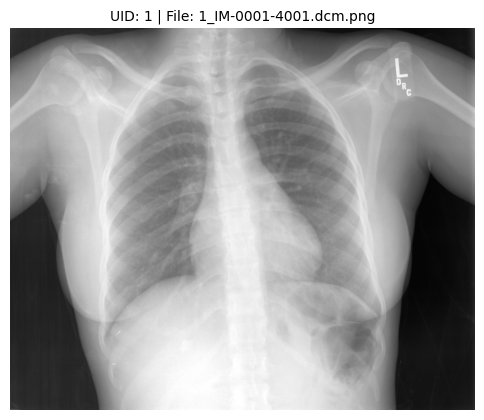

🔹 Original Finding:
The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.

🔹 Agent Output:
**FINDINGS:**

**Lungs and Pleura:** The lung fields are clear. No consolidation, infiltrates, or pneumothorax is identified. Vascular markings are normal. The pleura are unremarkable.

**Heart and Mediastinum:** The cardiac silhouette is within normal limits for size and contour. The mediastinal contour is normal.

**Aorta:** The visualized portion of the aorta appears normal.

**Pulmonary Arteries:** The main pulmonary arteries are not clearly delineated but appear within normal limits based on the visible structures.

**Diaphragm and Costophrenic Angles:** Both hemidiaphragms are well-defined and in their normal position. The right hemidiaphragm is slightly higher than the left, which is typical. The costophrenic angles are sharp and clear

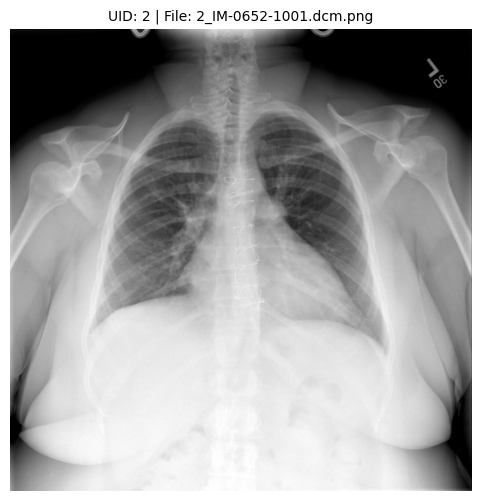

🔹 Original Finding:
Borderline cardiomegaly. Midline sternotomy XXXX. Enlarged pulmonary arteries. Clear lungs. Inferior XXXX XXXX XXXX.

🔹 Agent Output:
**1) Region-wise assessment:**

*   **Heart:**
    *   Status: Abnormal
    *   Findings: The cardiac silhouette appears enlarged. There are multiple surgical wires noted overlying the anterior cardiac silhouette, consistent with sternal closure.
*   **Aorta:**
    *   Status: Normal
    *   Findings: The visualized portions of the aorta appear unremarkable.
*   **Cardiac silhouette:**
    *   Status: Abnormal
    *   Findings: Enlarged cardiac silhouette. Surgical wires are present anteriorly.
*   **Diaphragm:**
    *   Status: Normal
    *   Findings: The diaphragmatic domes are well-defined and appear normal in position.
*   **Costophrenic angles:**
    *   Status: Normal
    *   Findings: The costophrenic angles are sharp and clear bilaterally.
*   **Hila:**
    *   Status: Normal
    *   Findings: The hila appear normal in size a

In [9]:
import matplotlib.pyplot as plt

if os.path.exists(OUTPUT_CSV):
    out = pd.read_csv(OUTPUT_CSV)

    for i, row in out.head(2).iterrows():
        img_path = os.path.join(IMAGES_FOLDER, row["filename"])
        
        if not os.path.exists(img_path):
            print(f"[{row['uid']}] Image not found: {row['filename']}")
            continue

        # Show image
        img = Image.open(img_path).convert("RGB")
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"UID: {row['uid']} | File: {row['filename']}", fontsize=10)
        plt.show()

        # Show text info
        print("🔹 Original Finding:")
        print(row["original_finding"])
        print("\n🔹 Agent Output:")
        print(row["final_report"])
        print("=" * 80)

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
import google.generativeai as genai
import json
import re

# ---------------- Gemini Setup ----------------
genai.configure(api_key="YOUR_GEMINI_API_KEY")  # or rely on GEMINI_API_KEY env var
model = genai.GenerativeModel("gemini-2.5-flash")

# ---------------- Eval Function ----------------
def judge_with_gemini(original_finding, final_report):
    prompt = f"""
You are acting as an impartial medical evaluator (LLM-as-a-judge). 
Compare the following two texts:

Original Finding:
{original_finding}

R4 Agent Output:
{final_report}

Evaluate along these 3 dimensions, and output ONLY a JSON object with keys:
- "similarity": float (0 to 1) → semantic meaning similarity.
- "professional_writing": float (0 to 1) → clarity, conciseness, and medical domain appropriateness of writing style.
- "correctness": float (0 to 1) → medical accuracy and correctness of findings.

Do not explain. Just output the JSON object.
"""

    response = model.generate_content(prompt)
    text = response.text.strip()

    # Clean common formatting issues
    text = re.sub(r"^```json", "", text)
    text = re.sub(r"^```", "", text)
    text = re.sub(r"```$", "", text)
    text = text.strip()

    try:
        scores = json.loads(text)
        return (
            float(scores.get("similarity", 0)),
            float(scores.get("professional_writing", 0)),
            float(scores.get("correctness", 0)),
        )
    except Exception as e:
        print("⚠️ Parsing error:", e, "Raw response:", text)
        return (0.0, 0.0, 0.0)

# ---------------- Main Script ----------------
OUTPUT_CSV = "gemini_zero_shot_results_batch.csv"
EVAL_CSV   = "r4_agent_eval_results.csv"

if os.path.exists(OUTPUT_CSV):
    df = pd.read_csv(OUTPUT_CSV).head(100).copy()

    sims, pros, corrs = [], [], []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Gemini LLM-as-a-judge"):
        s, p, c = judge_with_gemini(row["original_finding"], row["final_report"])
        sims.append(s); pros.append(p); corrs.append(c)

    df["similarity"] = sims
    df["professional_writing"] = pros
    df["correctness"] = corrs

    df.to_csv(EVAL_CSV, index=False)
    print(f"✅ Evaluation done. Saved to {EVAL_CSV}")

Gemini LLM-as-a-judge: 100%|██████████| 100/100 [43:23<00:00, 26.04s/it]

✅ Evaluation done. Saved to r4_agent_eval_results.csv
